In [1]:
import os
os.chdir("../")
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch
from gpytorch.kernels import RBFKernel, ScaleKernel, PeriodicKernel, MaternKernel, CosineKernel
from skgpytorch.models import SVGPRegressor, SGPRegressor

In [3]:
import jax.numpy as jnp
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from utilities.fits import fit
# from utilities import plot
import tensorflow_probability.substrates.jax as tfp
dist = tfp.distributions
import pandas as pd
import jax.numpy as jnp
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from gpytorch.constraints import GreaterThan
from skgpytorch.metrics import mean_squared_error, negative_log_predictive_density
import time
import numpy as np

# from datasets.dataset_load import dataset_loader
from utilities import plot,fits,gmm,errors,predict,preprocess

# device = "cpu"
# torch.set_default_dtype(torch.float32)
# torch.set_default_tensor_type(torch.FloatTensor)


In [4]:
train ={
    1: {
          'start_time': "2011-04-28" ,
          'end_time': "2011-05-15"
        },
    3: {
          'start_time': "2011-04-19" ,
          'end_time': "2011-05-22"
    }
}
test = {
     2: {
          'start_time': "2011-04-21" ,
          'end_time': "2011-05-21"
    }
}
appliances = ["Dish Washer"]

In [5]:

def dataset_loader(appliances, train, test=None):
    x_train = []
    y_train = []
    x_train_timestamp = []
    scaler_x = StandardScaler()
    scaler_y = StandardScaler()
    scaler_time = StandardScaler()
    # train
    # torch.set_default_dtype(torch.float64)
    for key, values in train.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()
        

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
    
        timestamp_train = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_train.extend(torch.tensor(x))
        y_train.extend(torch.tensor(y))
        x_train_timestamp.extend(torch.tensor(timestamp_train))


    x_train = torch.tensor(x_train).reshape(-1, 1)
    y_train = torch.tensor(y_train).reshape(-1, 1)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(-1,1)
    x_train = scaler_x.fit_transform(x_train)
    y_train = scaler_y.fit_transform(y_train)
    x_train_timestamp = scaler_time.fit_transform(x_train_timestamp)



    # test
    x_test = []
    y_test = []
    x_test_timestamp = []
    for key, values in test.items():
        df = pd.read_csv(
            f"datasets/Building{key}_NILM_data_basic.csv", usecols=["Timestamp", "main", appliances[0]])
        df["date"] = pd.to_datetime(df["Timestamp"]).dt.date
        startDate = datetime.strptime(values["start_time"], "%Y-%m-%d").date()
        endDate = datetime.strptime(values["end_time"], "%Y-%m-%d").date()

        if startDate > endDate:
            raise "Start Date must be smaller than Enddate."

        df = df[(df["date"] >= startDate) & (df["date"] <= endDate)]
        df.dropna(inplace=True)
        x = df["main"].values
        y = df[appliances[0]].values
        timestamp = (pd.to_datetime(df["Timestamp"]).astype(int)/ 10**18).values

        x_test.extend(torch.tensor(x))
        y_test.extend(torch.tensor(y))
        x_test_timestamp.extend(timestamp)

    x_test = torch.tensor(x_test).reshape(-1, 1)
    y_test = torch.tensor(y_test).reshape(-1, 1)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(-1,1)

    x_test = scaler_x.transform(x_test)
    x_test_timestamp = scaler_time.transform(x_test_timestamp)

    x_train = torch.tensor(x_train).reshape(x_train.shape[0], 1)
    y_train = torch.tensor(y_train).reshape(-1,)
    x_train_timestamp = torch.tensor(x_train_timestamp).reshape(x_train_timestamp.shape[0], 1)
    x_test = torch.tensor(x_test).reshape(x_test.shape[0], 1)
    y_test = torch.tensor(y_test).reshape(-1,)
    x_test_timestamp = torch.tensor(x_test_timestamp).reshape(x_test_timestamp.shape[0], 1)


    return x_train, y_train, x_test, y_test, x_train_timestamp, x_test_timestamp, scaler_x, scaler_y


In [6]:
x_train, y_train, x_test, y_test, x_train_timstamp, x_test_timestamp, scaler_x, scaler_y = dataset_loader(appliances, train, test)

/tmp/ipykernel_3346619/3396249836.py:77: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test).reshape(-1,)


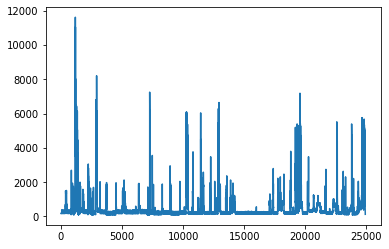

In [7]:
plt.plot(scaler_x.inverse_transform(x_train))

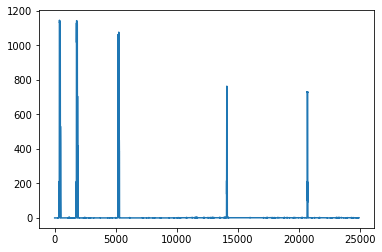

In [8]:
plt.plot(scaler_y.inverse_transform(y_train.reshape(-1,1)))

In [27]:
y_trans = scaler_y.inverse_transform(y_train.reshape(-1,1))

unique = np.unique(y_trans)
unique

(array([0.00000000e+00, 5.88235300e-02, 6.25000000e-02, 6.66666700e-02,
        7.14285750e-02, 1.00000000e-01, 1.17647060e-01, 1.25000000e-01,
        1.33333340e-01, 1.87500000e-01, 2.00000000e-01, 2.14285720e-01,
        2.50000000e-01, 2.66666680e-01, 2.94117660e-01, 3.12500000e-01,
        3.33333340e-01, 3.57142870e-01, 3.75000000e-01, 4.00000000e-01,
        4.28571430e-01, 4.37500000e-01, 4.61538460e-01, 4.66666670e-01,
        4.70588240e-01, 5.00000000e-01, 5.29411800e-01, 5.33333360e-01,
        5.62500000e-01, 5.88235300e-01, 6.00000000e-01, 6.25000000e-01,
        6.66666700e-01, 6.87500000e-01, 7.33333350e-01, 7.50000000e-01,
        7.64705900e-01, 8.00000000e-01, 8.12500000e-01, 8.23529400e-01,
        8.33333300e-01, 8.57142870e-01, 8.66666700e-01, 8.75000000e-01,
        8.82352950e-01, 8.88888900e-01, 9.00000000e-01, 9.16666700e-01,
        9.23076900e-01, 9.28571400e-01, 9.33333340e-01, 9.37500000e-01,
        9.41176500e-01, 1.00000000e+00, 1.06250000e+00, 1.066666

In [21]:
y_class =np.zeros(y_train.shape[0])
print(y_class.shape)
np.where(scaler_y.inverse_transform(y_train.reshape(-1,1))>600,1.0,y_class)
np.where(scaler_y.inverse_transform(y_train.reshape(-1,1))<1200,1.0, y_class)

(24918,)


array([[1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

In [22]:
y_class.shape

(24918,)

In [23]:
unique, counts = np.unique(y_class.reshape(-1,1), return_counts=True)

In [24]:
unique


array([0.])

 ...]

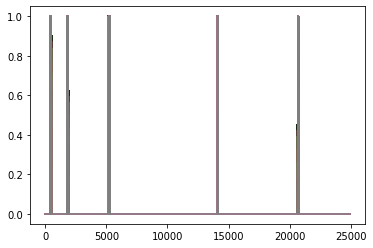

In [93]:
plt.plot(y_class)

In [94]:
y_class.shape

(24918, 24918)